<a href="https://colab.research.google.com/github/ilkelatifoglu/face_recognition/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
csv_path = "/content/drive/MyDrive/face recognition dataset/Dataset.csv"
image_folder = "/content/drive/MyDrive/face recognition dataset/Faces"

Mounted at /content/drive


In [2]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import LeakyReLU


In [4]:
df = pd.read_csv(csv_path, sep=';')
print(df.head())

                        id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan


In [5]:
# image_files is a list of image file names one can loop through
image_files = os.listdir(image_folder)
image_files = sorted(image_files)

In [6]:
resized_images = []
image_ids = []
for filename in image_files:
    file_path = os.path.join(image_folder, filename)

    # Read and resize the image to 128 x 128
    img = cv2.imread(file_path)
    resized_img = cv2.resize(img, (128, 128))

    # OpenCV loads in BGR by default, so convert to RGB
    img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to [0, 1]
    img_normalized = img_rgb / 255.0

    # Append the preprocessed image to the list
    resized_images.append(img_normalized)
    image_ids.append(filename.split('.')[0])

# Check the shape of the first resized image
print(f"Shape of the first resized image: {resized_images[0].shape}")
# Check the data type of the images after normalization
print(f"Data type after normalization: {img_normalized.dtype}")
# Check the pixel range after normalization
print(f"Pixel range after normalization: min={img_normalized.min()}, max={img_normalized.max()}")

resized_images = np.array(resized_images)
df['image_id'] = df['id'].apply(lambda x: x.split('.')[0])
print("CSV image IDs:", df['image_id'].head())
print("File image IDs:", image_ids[:5])

image_dict = {}  # Initialize an empty dictionary

for i in range(len(image_ids)):
    key = image_ids[i]
    value = resized_images[i]
    image_dict[key] = value

def get_image(image_id):
    return image_dict.get(image_id, None)

df['image'] = df['image_id'].apply(get_image)
print(df.head())

first_image_data = df.iloc[0]['image']
print(f"Image data for the first record: {first_image_data.shape}")


Shape of the first resized image: (128, 128, 3)
Data type after normalization: float64
Pixel range after normalization: min=0.00392156862745098, max=0.9372549019607843
CSV image IDs: 0    Robert Downey Jr_87
1         Lisa Kudrow_64
2     Ellen Degeneres_34
3        Billie Eilish_3
4      Hrithik Roshan_35
Name: image_id, dtype: object
File image IDs: ['Akshay Kumar_0', 'Akshay Kumar_1', 'Akshay Kumar_10', 'Akshay Kumar_11', 'Akshay Kumar_12']
                        id             label             image_id  \
0  Robert Downey Jr_87.jpg  Robert Downey Jr  Robert Downey Jr_87   
1       Lisa Kudrow_64.jpg       Lisa Kudrow       Lisa Kudrow_64   
2   Ellen Degeneres_34.jpg   Ellen Degeneres   Ellen Degeneres_34   
3      Billie Eilish_3.jpg     Billie Eilish      Billie Eilish_3   
4    Hrithik Roshan_35.jpg    Hrithik Roshan    Hrithik Roshan_35   

                                               image  
0  [[[0.18823529411764706, 0.011764705882352941, ...  
1  [[[0.8156862745098039, 0

In [7]:
X = np.array(df['image'].tolist())
y = np.array(df['label'].values)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded  # ensures class balance in training and test
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2049, 128, 128, 3)
Test data shape: (513, 128, 128, 3)


In [8]:
class FaceRecognitionHyperModel(kt.HyperModel):

  def build(self, hp):

      model = Sequential([
          #(3×3×3+1)×128=(27+1)×128=28×128=3,584 parameters
          Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          #(3×3×128+1)×128=(1,152+1)×128=1,153×128=147,584 parameters
          Conv2D(128, (3, 3), activation='relu', padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          Conv2D(128, (3, 3), activation='relu', padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          Conv2D(128, (3, 3), activation='relu', padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          Conv2D(128, (3, 3), activation='relu', padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          Conv2D(128, (3, 3), activation='relu', padding='same'),
          BatchNormalization(),
          MaxPooling2D(2, 2),
          Flatten(),
          Dropout(0.5),
          #after flattening we have an array with 512 weigths, in the dense layer we have 128 neurons. each neuron is connected to all the weights so
          #(512+1)×128=513×128=65,664 parameters
          Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.5)),
          Dropout(0.5),
          Dense(len(np.unique(y)), activation='softmax')
      ])

      lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
      model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      return model

  def fit(self, hp, model, *args, **kwargs):
      batch_size = hp.Choice("batch_size", [16, 32, 64])
      epochs = hp.Int("epochs", 30, 60, step=10)
      early_patience = hp.Int("early_patience", 5, 20, step=5)
      lr_patience = hp.Int("lr_patience", 3, 10)
      lr_factor = hp.Choice("lr_factor", [0.2, 0.5, 0.8])

      custom_callbacks = [
          EarlyStopping(monitor='val_loss', patience=early_patience, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=lr_patience, min_lr=1e-6)
      ]

      # Merge with any callbacks already passed in kwargs
      if "callbacks" in kwargs:
          kwargs["callbacks"] += custom_callbacks
      else:
          kwargs["callbacks"] = custom_callbacks

      return model.fit(
          *args,
          batch_size=batch_size,
          epochs=epochs,
          **kwargs
      )

In [9]:
hypermodel = FaceRecognitionHyperModel()

tuner = kt.RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_logs',
    project_name='face_hyperparam_search'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test))


Trial 10 Complete [00h 00m 21s]
val_accuracy: 0.08187134563922882

Best val_accuracy So Far: 0.9005848169326782
Total elapsed time: 00h 07m 30s


In [10]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters found:")
print(f"Learning rate: {best_hp.get('learning_rate')}")
print(f"Batch size: {best_hp.get('batch_size')}")
print(f"EarlyStopping patience: {best_hp.get('early_patience')}")
print(f"LR Reduce factor: {best_hp.get('lr_factor')}")
print(f"LR patience: {best_hp.get('lr_patience')}")
print(f"Epochs: {best_hp.get('epochs')}")

Best hyperparameters found:
Learning rate: 0.0003946423822593413
Batch size: 16
EarlyStopping patience: 20
LR Reduce factor: 0.2
LR patience: 5
Epochs: 50


In [11]:
# Build and compile best model
model = tuner.hypermodel.build(best_hp)

# Train the model using the best batch size and number of epochs
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=best_hp.get('batch_size'),
    epochs=best_hp.get('epochs'),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=best_hp.get('early_patience'),
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=best_hp.get('lr_factor'),
            patience=best_hp.get('lr_patience'),
            min_lr=1e-6
        )
    ]
)
model.summary()

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.0375 - loss: 84.6033 - val_accuracy: 0.0312 - val_loss: 32.4668 - learning_rate: 3.9464e-04
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0648 - loss: 24.4630 - val_accuracy: 0.0429 - val_loss: 9.8439 - learning_rate: 3.9464e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1488 - loss: 7.7437 - val_accuracy: 0.0409 - val_loss: 4.9586 - learning_rate: 3.9464e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2265 - loss: 4.0204 - val_accuracy: 0.2105 - val_loss: 3.5804 - learning_rate: 3.9464e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2682 - loss: 3.2125 - val_accuracy: 0.3645 - val_loss: 3.0222 - learning_rate: 3.9464e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3151 - loss: 2.9150 - val_accuracy: 0.3821 - val_loss: 2.7768 - learning_rate: 3.9464e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accur

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             

 Total params: 2,439,647 (9.31 MB)

 Trainable params: 812,703 (3.10 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 1,625,408 (6.20 MB)

In [13]:
model.export('/content/face_rec_model')

Saved artifact at '/content/face_rec_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)
Captures:
  132232924838992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226103827088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110995152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110981328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132232924838800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110989008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110993040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110986704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110989392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132226110984400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132

In [16]:
!cp -r /content/face_rec_model /content/drive/MyDrive/

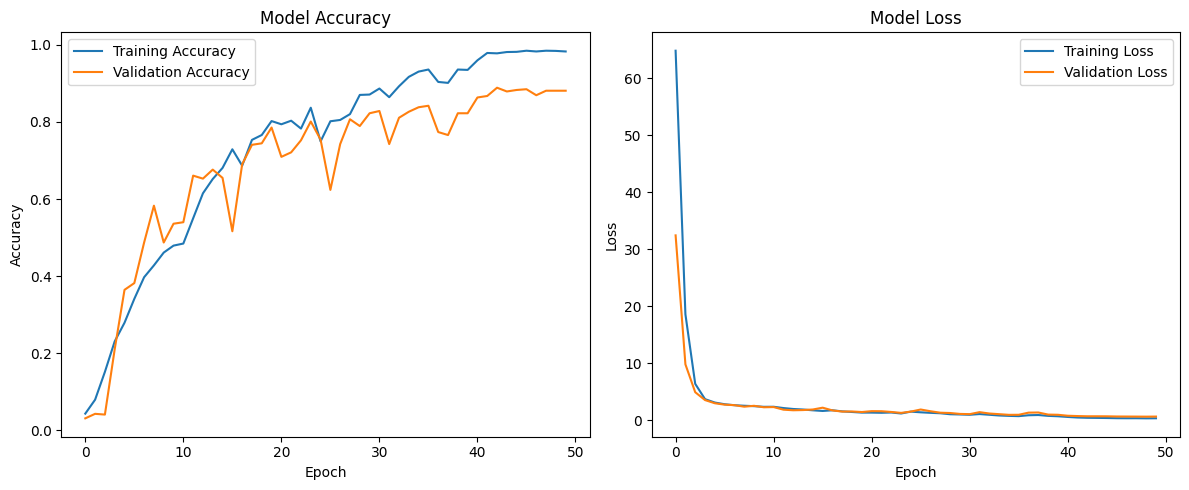

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


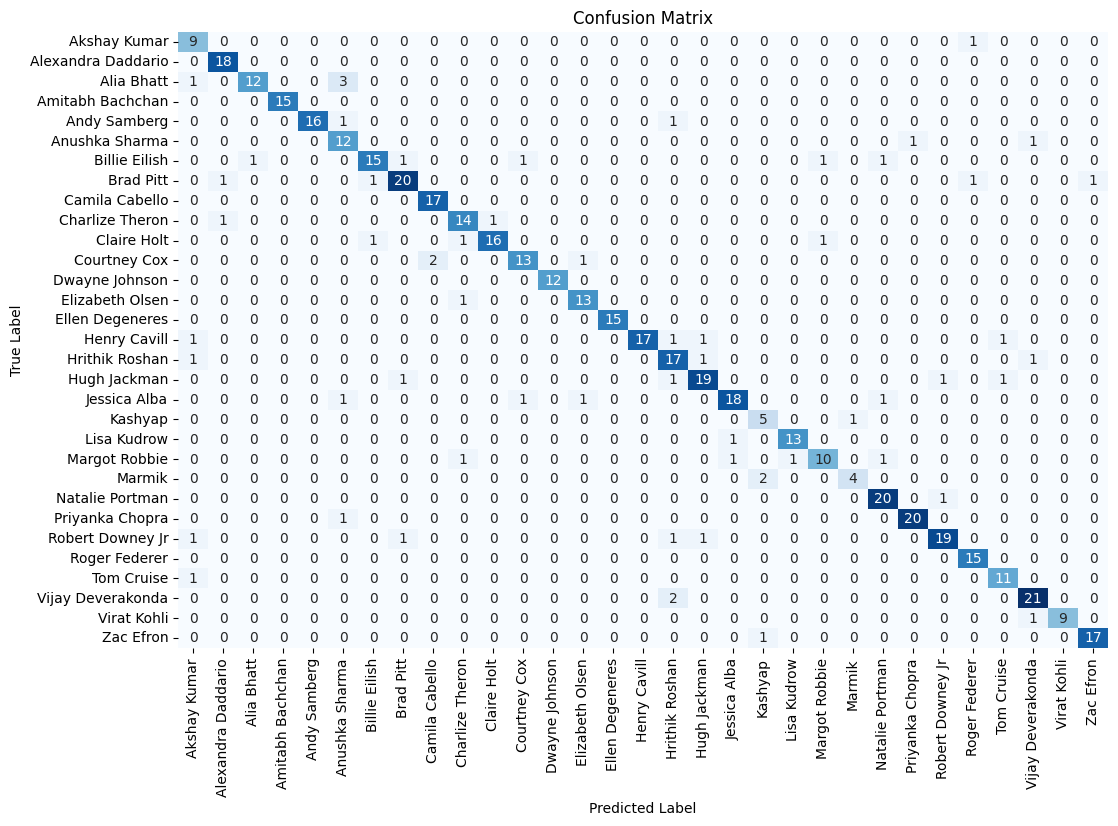

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.64      0.90      0.75        10
Alexandra Daddario       0.90      1.00      0.95        18
        Alia Bhatt       0.92      0.75      0.83        16
  Amitabh Bachchan       1.00      1.00      1.00        15
      Andy Samberg       1.00      0.89      0.94        18
    Anushka Sharma       0.67      0.86      0.75        14
     Billie Eilish       0.88      0.75      0.81        20
         Brad Pitt       0.87      0.83      0.85        24
    Camila Cabello       0.89      1.00      0.94        17
   Charlize Theron       0.82      0.88      0.85        16
       Claire Holt       0.94      0.84      0.89        19
      Courtney Cox       0.87      0.81      0.84        16
    Dwayne Johnson       1.00      1.00      1.00        12
   Elizabeth Olsen       0.87      0.93      0.90        14
   Ellen Degeneres       1.00      1.00      1.00        15
      Henry Cavi

In [14]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Create and plot confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert the predictions to class labels

class_labels = label_encoder.inverse_transform(np.unique(y_train))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Evaluation metrics (e.g., accuracy, precision, recall, F1-score)
report = classification_report(y_test, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Optionally, you can also print the overall accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Overall Accuracy: {accuracy:.4f}")